# Solution to the task

The task demands to search for a valid combination to win the game. This can be achieved by performing a Grover's search on all the possible combinations of input states out of the empty boxes. Thus, what's needed is to design an appropriate oracle which can pick out the winning combination from the set of all possible cases.

## The Approach

As it is known, the oracle for the search algorithm adds a negative phase to the search states. Thus, for each specific case, a unique oracle is designed, which identifies the valid combination for the game. Then, $\textbf{amplitude amplification}$ is applied on the state $|0\rangle^{\otimes4}$,using the Grover's diffusion operator. A single iteration of the procedure seemed enough to amplify the probability of win states in order to provide a decisive move with a higher probability.

## Importing the essential packages

In [1]:
from math import *
from numpy import *

from qiskit import *
from qiskit.circuit import *
from qiskit.circuit.library import *
from qiskit.quantum_info import *
from qiskit.visualization import *

## Initializing the circuit

The following function takes the "number of qubits" as an input argument, and then creates a "Quantum Cirucit" object, upon which hadamard is applied to all the qubits to bring all the states in an uniform superposition.

The function then returns the modified circuit(with equal superposition of states) as a "Quantum Circuit" object.

In [2]:
def initial_state(qbits):
    qc = QuantumCircuit(qbits)
    qc.h(range(qbits))
    
    return qc

## Defining the oracle

For this specific case, this oracle has been defined which establishes the search criterion for the valid combinations of moves.

In [3]:
def valid_combinations():
    oracle = QuantumCircuit(4)
    mcz = ZGate().control(2)
    for i in range(3):
        oracle.cz(i, range(i+1, 4))
    for i in range(4):
        oracle = oracle.compose(mcz, list(range(3-i))+list(range(4-i, 4)))
    
    return oracle

## Grover's Diffusion Operator

The following function takes the number of qubits as an input argument and creates a general diffuser for any number of qubits, provided. It returns the diffusion operator as a "Quantum Circuit" object.

In [4]:
def diffuser(qbits):
    gd_operator = QuantumCircuit(qbits)
    gd_operator.h(range(qbits))
    gd_operator.x(range(qbits))
    gd_operator = gd_operator.compose(ZGate().control(qbits-1), range(qbits))
    gd_operator.x(range(qbits))
    gd_operator.h(range(qbits))
    
    return gd_operator

For this specific case, the number of turns(i.e., 4) corresponds to the number of qubits involved in the circuit.

The following code snippet creates such a "Quantum Circuit" with 4 qubits, initializes them into an equal superposition, and isolate outs the valid states from the complete set. The circuit specific to this case is also shown as an output to the snippet.

In [5]:
n_qbit = 4    #number of qubits involved

grover_circuit = initial_state(4)
grover_circuit = grover_circuit.compose(valid_combinations(), range(4))
grover_circuit = grover_circuit.compose(diffuser(4), range(4))
grover_circuit.draw(fold=-1)

┌───┐                           ┌───┐┌───┐        ┌───┐┌───┐
q_0: ┤ H ├─■──■──■───────────■──■──■─┤ H ├┤ X ├──────■─┤ X ├┤ H ├
     ├───┤ │  │  │           │  │  │ └───┘├───┤┌───┐ │ ├───┤├───┤
q_1: ┤ H ├─■──┼──┼──■──■─────■──■──┼───■──┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤    │  │  │  │     │  │  │   │  ├───┤├───┤ │ ├───┤├───┤
q_2: ┤ H ├────■──┼──■──┼──■──■──┼──■───■──┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤       │     │  │     │  │   │  ├───┤├───┤ │ ├───┤├───┤
q_3: ┤ H ├───────■─────■──■─────■──■───■──┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘                                └───┘└───┘   └───┘└───┘

The "qasm-simulator" backend from the "qiskit" module has been used to simulate and execute the circuit in order to get the prababilities of all the valid states from the circuit.

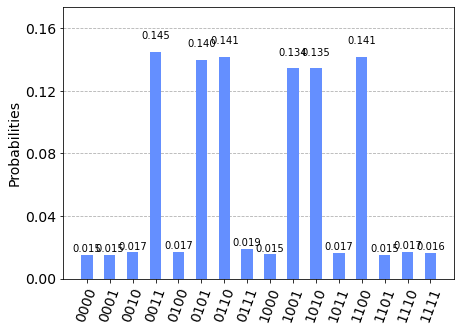

In [6]:
backend = Aer.get_backend('qasm_simulator')
gv_sim = transpile(grover_circuit, backend)
gv_sim.measure_all()

result = backend.run(gv_sim, shots=10000).result()
counts = result.get_counts()
plot_histogram(counts)

As we can from the bar chart, that the circuit is able to isolate out the valid moves from the complete set of combinations. But, as it is obvious, not all valid combinations are winning moves.

Hence, another search criterion needs to be set which can select out the winning combination from this set of valid moves.

In [7]:
def winning_combinations():
    oracle2 = QuantumCircuit(4)
    oracle2.cz([0, 0, 1, 1], [1, 2, 2, 3])
    mcz = ZGate().control(2)
    oracle2 = oracle2.compose(mcz, range(3))
    oracle2 = oracle2.compose(mcz, [0, 2, 3])
    
    return oracle2

In [8]:
grover_circuit = grover_circuit.compose(winning_combinations(), range(4))
grover_circuit = grover_circuit.compose(diffuser(4), range(4))
grover_circuit.draw(fold=-1)

┌───┐                           ┌───┐┌───┐        ┌───┐┌───┐                  ┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├─■──■──■───────────■──■──■─┤ H ├┤ X ├──────■─┤ X ├┤ H ├─■──■────────■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤ │  │  │           │  │  │ └───┘├───┤┌───┐ │ ├───┤├───┤ │  │        │  │ ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├─■──┼──┼──■──■─────■──■──┼───■──┤ H ├┤ X ├─■─┤ X ├┤ H ├─■──┼──■──■──■──┼─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤    │  │  │  │     │  │  │   │  ├───┤├───┤ │ ├───┤├───┤    │  │  │  │  │ ├───┤├───┤ │ ├───┤├───┤
q_2: ┤ H ├────■──┼──■──┼──■──■──┼──■───■──┤ H ├┤ X ├─■─┤ X ├┤ H ├────■──■──┼──■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤       │     │  │     │  │   │  ├───┤├───┤ │ ├───┤├───┤          │     │ ├───┤├───┤ │ ├───┤├───┤
q_3: ┤ H ├───────■─────■──■─────■──■───■──┤ H ├┤ X ├─■─┤ X ├┤ H ├──────────■─────■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘                                └───┘└───┘   └───┘└───┘                  └───┘└───┘   └───┘└───┘

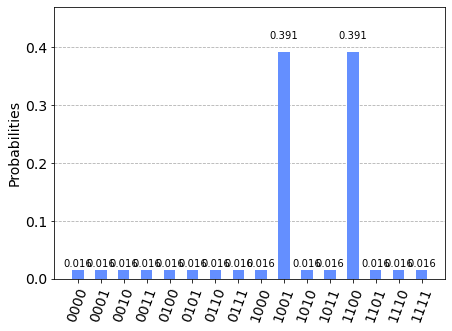

In [9]:
t_gv = transpile(grover_circuit, backend)
t_gv.save_statevector()
result = backend.run(t_gv, shots=10000).result()
counts = result.get_counts()
plot_histogram(counts)

As we can see from the above bar chart, that the states $|1001\rangle$ and $|1100\rangle$, respectively corresponding to the combinations $XOOX$ and $XXOO$, have the highest probability, thus indicating the valid combinations the player needs to make in order to play the game.

## The Strategy to Win

Now, the previous bar chart only provided the valid combinations to win, but it lacked the capability to provide any information on which move to make i.e. at which index should the player make his move in order to win.

The following function compensates for that by performing a measurement on each of the qubit of the "Quantum Circuit" and recording the numbers of 'ones'(i.e., the $X$'s), which then can be used to calculate the probability of the index for the next move.

In [10]:
def strategize(qc, backend):
    cr = ClassicalRegister(1)
    qc.add_register(cr)
    num_list = []
    for i in range(qc.num_qubits):
        qc_copy = qc.copy()
        qc_copy.measure(i, 0)
        t_qc = transpile(qc_copy, backend)
        result = backend.run(t_qc).result()
        counts = result.get_counts()
        num_list.append(counts['1'])
    
    return num_list

In [11]:
import numpy as np

num1 = strategize(t_gv.reverse_bits(), backend)
num1 = np.array(num1)
total = num1.sum()
num_per = num1/total*100
print("The list of the probabilities of the indices to win ", num_per)
print("You should play the next move at index ", np.argmax(num_per)+1)

The list of the probabilities of the indices to win  [44.28500742 23.84957942  6.28401781 25.58139535]
You should play the next move at index  1


As we can see, the above code snippet can calculate the probablity to win based on the indices for '1'(i.e. the $X$). Here, it displays this list of probablities as a numpy array where the index with the highest probability is the best position to make a move.

Not only does the array indicate the next move of the player, but it also predicts the future indices that the player should play in order to win. In this case, after index '1', the player should play index '2' or '4' in his second chance to win the game.

This above information can be plotted as a bar chart, as shown below.

Text(0.5, 0, 'Position indices')

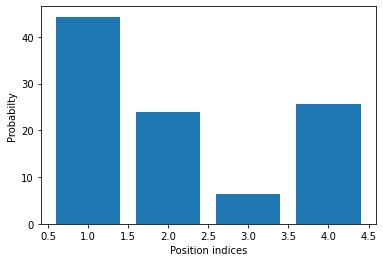

In [12]:
from matplotlib import pyplot as plt

x = range(1, 5)
y = num_per
plt.bar(x, y)
plt.ylabel('Probabilty')
plt.xlabel('Position indices')

## Perfecting the Code
Although, the above set of codes can produce the decisive moves with certainty, it is not accurate. This is because the code differentiates the valid combinations from the invalid ones(like $|0000\rangle$ corresponding to the move $OOOO$) and then isolate outs the winning combination from the set.

This is inefficient as it's pretty obvious that the invalid combinations are not gonna be the winning moves. A more efficient algorithm need not seperate the valid moves from the invalid ones, and instantly isolate out the winning moves from the whole set of combinations.

Hence, the search criterion must be modified such that it can isolate out the winning combination of moves in a single pass.

In [13]:
def oracle():
    qc = QuantumCircuit(4)
    qc.cz(0, [1, 3])
    mcz = ZGate().control(2)
    qc = qc.compose(mcz, range(3))
    qc = qc.compose(mcz, [0, 2, 3])
    
    return qc

Such a circuit with above mentioned modification should look like the one below.

In [14]:
n_qbit = 4

grover_circuit = initial_state(n_qbit)
grover_circuit = grover_circuit.compose(oracle(), range(n_qbit))
grover_circuit = grover_circuit.compose(diffuser(n_qbit), range(n_qbit))
grover_circuit = grover_circuit.reverse_bits()
grover_circuit.draw(fold=-1)

┌───┐            ┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├────■─────■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤    │     │ ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├────┼──■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤    │  │  │ ├───┤├───┤ │ ├───┤├───┤
q_2: ┤ H ├─■──┼──■──┼─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤ │  │  │  │ ├───┤├───┤ │ ├───┤├───┤
q_3: ┤ H ├─■──■──■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘            └───┘└───┘   └───┘└───┘

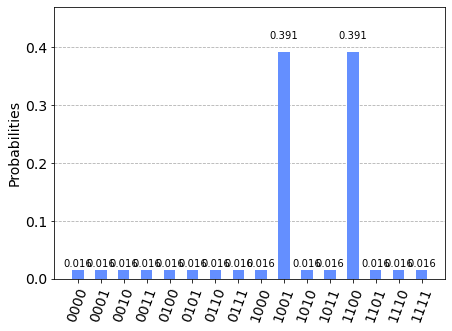

In [15]:
backend = Aer.get_backend("qasm_simulator")
t_gv = transpile(grover_circuit, backend)
t_gv.save_statevector()
result = backend.run(t_gv).result()
counts = result.get_counts()
plot_histogram(counts)

We can see that the circuit is able to get the winning moves in a single iteration, unlike the previous case which used two different oracles to perform the same task. But, upon performing the strategic measurement, we should be able to decide the next move, just like in the previous case.

In [16]:
num1 = strategize(t_gv.reverse_bits(), backend)
num1 = np.array(num1)
total = num1.sum()
num_per = num1/total*100
print("The list of the probabilities of the indices to win ", num_per)
print("You should play the next move at index ", np.argmax(num_per)+1)

The list of the probabilities of the indices to win  [43.94379845 25.58139535  5.71705426 24.75775194]
You should play the next move at index  1


Text(0.5, 0, 'Position indices')

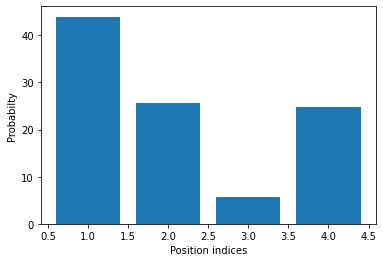

In [17]:
x = range(1, 5)
y = num_per
plt.bar(x, y)
plt.ylabel('Probabilty')
plt.xlabel('Position indices')

# Bonus

## Defining the oracle

Similar to the orevious cases, a unique oracle has to be defined which inverts the phase of the search states and finds the winning combination to win.

In [18]:
def oracle():
    oracle = QuantumCircuit(5)
    mcz = ZGate().control(2)
    oracle.cz(0, [1, 2, 4])
    oracle.cz(1, 2)
    oracle.cz(2, [3, 4])
    oracle = oracle.compose(mcz, range(3))
    oracle = oracle.compose(mcz, list(range(2))+[3])
    oracle = oracle.compose(mcz, [0, 2, 4])
    oracle = oracle.compose(mcz, [0, 3, 4])
    oracle = oracle.compose(mcz.control(1), range(1, 5))
    oracle = oracle.compose(mcz.control(1), list(range(3))+[4])
    
    return oracle

The circuit for the bonus case is as shown below.

In [19]:
n_qbit = 5

gc = initial_state(n_qbit)
gc = gc.compose(oracle(), range(n_qbit))
gc = gc.compose(diffuser(n_qbit))
gc = gc.reverse_bits()
gc.draw(fold=-1)

┌───┐                                    ┌───┐┌───┐   ┌───┐┌───┐
q_0: ┤ H ├───────■────────■────────■──■──■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤       │        │        │  │  │  │ ├───┤├───┤ │ ├───┤├───┤
q_1: ┤ H ├───────┼─────■──┼─────■──┼──■──■──┼─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤       │     │  │     │  │  │  │  │ ├───┤├───┤ │ ├───┤├───┤
q_2: ┤ H ├────■──┼──■──■──■──■──┼──■──┼──■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤    │  │  │        │  │  │  │  │  │ ├───┤├───┤ │ ├───┤├───┤
q_3: ┤ H ├─■──┼──┼──■────────■──■──┼──┼──■──■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     ├───┤ │  │  │           │  │  │  │     │ ├───┤├───┤ │ ├───┤├───┤
q_4: ┤ H ├─■──■──■───────────■──■──■──■─────■─┤ H ├┤ X ├─■─┤ X ├┤ H ├
     └───┘                                    └───┘└───┘   └───┘└───┘

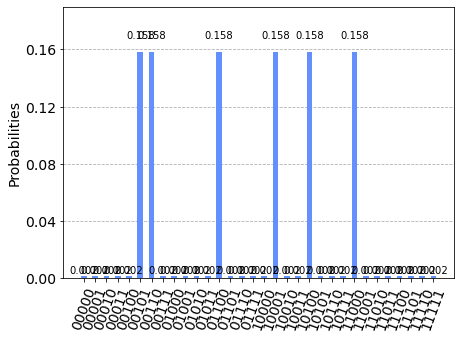

In [20]:
backend = Aer.get_backend("qasm_simulator")
t_gc = transpile(gc, backend)
t_gc.save_statevector()
result = backend.run(t_gc).result()
counts = result.get_counts()
plot_histogram(counts)

Above is the bar chart representing all the winning combinations for the case.

In [21]:
num1 = strategize(t_gc.reverse_bits(), backend)
num1 = np.array(num1)
total = num1.sum()
num_per = num1/total*100
print("The list of the probabilities of the indices to win ", num_per)
print("You should play the next move at index ", np.argmax(num_per)+1)

The list of the probabilities of the indices to win  [24.42857143 17.0952381  33.0952381   7.95238095 17.42857143]
You should play the next move at index  3


Text(0.5, 0, 'Position indices')

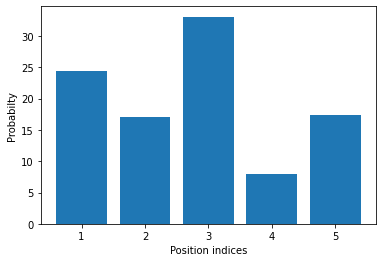

In [22]:
x = range(1, 6)
y = num_per
plt.bar(x, y)
plt.ylabel('Probabilty')
plt.xlabel('Position indices')

Now, as in the original case, if the winning combination was 
$\big(\begin{smallmatrix}
  X & X\\
  O & O
\end{smallmatrix}\big)$, 
it was represented as $|1100\rangle$. Similarly, in the bonus case, when the opponent is yet to play his move, a combination like 
$\big(\begin{smallmatrix}
      & X & O\\
    X & O & O
\end{smallmatrix}\big)$ 
is represented as $|10100\rangle$.

Thus, we can see that the algorithm is able to find the best move with enough certainty. According to the above bar chart, the player should play his next move at index 3. Even if the player misses this move, the code has already predicted (without any modification to it) the best move which is index 1 and then 2 or 5.

In [23]:
import qiskit.tools.jupyter
%qiskit_version_table